In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import datetime
import arviz
import seaborn as sns
sns.set()

In [2]:
from nowcasting_functions import *

In [3]:
data = pd.read_csv('data/df_SIVEP_nowcast_Brazil_31-05-2021.csv')
data_new = data.copy()

In [4]:
nowcast_date = '2021-02-07'

In [5]:
# Prepare the data for nowcast
data_new['Release_index'] = data_new.Release.astype('category').cat.codes
data_new = data_new[data_new['Date'] >= '2020-06-30'] # cut off early days as they are less relevant
data_new = data_new[data_new['Release'] >= '2020-06-30'] # cut off early days as they are less relevant

In [6]:
data_recent = data.copy()
data_recent = data_recent[data_recent.Date > '2020-06-30']

In [7]:
def plot_results(df, result_nowcast, show_x=True, show_y=True, show_legend=True):
    date_nowcast = df['Date'].values[-1]
    reported, _ = nowcasting_prep(df, date_nowcast, maxD=10)
    nowcasted = result_nowcast
    
    x = reported.index + 27

    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '_95% CrI', color = 'orange')
    label = 'GP model nowcast' # '50% CrI'
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = label, color = 'orange')

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color='blue')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

In [50]:
def plot_results_with_annotation(df, df_recent, result_nowcast, show_x=True, show_y=True, show_legend=True):
    date_nowcast = df['Date'].values[-1]
    reported, _ = nowcasting_prep(df, date_nowcast, maxD=10)
    true, _ = nowcasting_prep(df_recent, df_recent['Date'].values[-1], maxD=10)

    nowcasted = result_nowcast
    
    c1 = 'orange' # or 'tab:orange'
    c2 = 'blue' # or 'tab:blue'
    c3 = 'red'

    x = reported.index + 27
    true = true.iloc[0:len(x),:]
    
    plt.fill_between(x, y1=nowcasted['q025'].values,
                     y2=nowcasted['q975'].values, alpha = 0.3, 
                     label = '_95% CrI', color = c1)
    
    label = 'GP model nowcast' # '50% CrI'
    plt.fill_between(x, y1=nowcasted['q25'].values,
                     y2=nowcasted['q75'].values, alpha = 0.6, 
                     label = label, color = c1)

    plt.scatter(reported.index+27, reported.all_deaths.values, 
             label = 'reported', color=c2)
    
    plt.plot(true.index+27, true.all_deaths.values, 
             label = 'true', color=c3)

    plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
    plt.yticks(range(2000,11000,2000), fontsize=12)

    plt.text(max(x)-13, 8000, '2D GP model\nnowcast', color = 'tab:orange', size=16)
#     plt.text(max(x)-12, 8000, 'Model\nnowcast', color = 'tab:orange', size=16)
    plt.text(max(x)-8, 4000, 'Reported', color = c2, size=16)
    plt.text(max(x)+1, 7500, 'True', color = c3, size=16)

    plt.xlim([min(x), max(x)+5])
    
    if show_x:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_y:
        plt.ylabel('Number of deaths per week', fontsize=16)
    if show_legend:
        plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()

### 2D GP models

In [9]:
model_2d_mixture = pystan.StanModel(file='stan_models/2D_mixture.stan')
model_2d_additive = pystan.StanModel(file='stan_models/2D_additive.stan')

print('Models compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68fff2d5b71ca907310db522a2832501 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13ce707f9d16c4c107698b47ab71cf4f NOW.


Models compiled


In [10]:
fit_2d_add, results_2d_add = fit_model(data_new, precompiled=False, modelname=model_2d_additive, date_nowcast=nowcast_date,
              maxD=12, iters=1000, warmup=400, chains=4, adapt_delta=0.95,
              max_treedepth=12, seed=66,
              pickle_run=False, save=False, savepath='')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
# fit_2d_mix, results_2d_mix = fit_model(data_new, precompiled=False, modelname=model_2d_mixture, date_nowcast=nowcast_date,
#               maxD=12, iters=1000, warmup=400, chains=4, adapt_delta=0.95,
#               max_treedepth=12, seed=666,
#               pickle_run=False, save=False, savepath='')

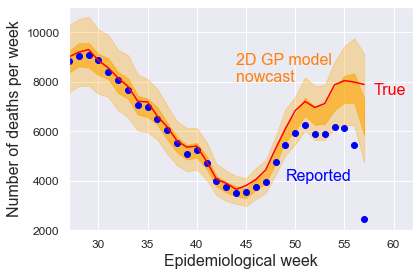

In [51]:
plot_results_with_annotation(data_new[data_new['Release'] <= '2021-02-08'],
                             data_recent, results_2d_add, show_x=True, show_y=True, show_legend=False)
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/brazil_nowcast_2D_additive.pdf', bbox_inches = 'tight')

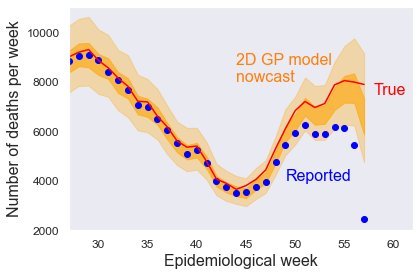

In [52]:
sns.set_style("dark")

plot_results_with_annotation(data_new[data_new['Release'] <= '2021-02-08'],
                             data_recent, results_2d_add, show_x=True, show_y=True, show_legend=False)
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/brazil_nowcast_2D_additive_slides.pdf', bbox_inches = 'tight')
sns.set()

In [ ]:
# plot_results_with_annotation(data_new[data_new['Release'] <= '2021-02-08'],
#                              data_recent, results_2d_mix, show_x=True, show_y=True, show_legend=False)

### 4xSE GP model

In [ ]:
model_4compSE = pystan.StanModel(file='stan_models/4comp_longshort_SE.stan')
print('Model compiled')

In [ ]:
fit_4compSE, results4compSE = fit_model(data_new, precompiled=False, modelname=model_4compSE, date_nowcast=None,
              maxD=12, iters=1000, warmup=400, chains=4, adapt_delta=0.9,
              max_treedepth=12, seed=666,
              pickle_run=False, save=False, savepath='')

In [ ]:
plot_results_with_annotation(data_new[data_new['Release'] <= '2021-02-08'],
                             data_recent, results4compSE, show_x=True, show_y=True, show_legend=False)

### NobBS model

In [12]:
model_nobbs = pystan.StanModel(file='stan_models/nobbs.stan')
print('Model compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50ab4c0f87d41cc6e3e4c401019d3bf2 NOW.


Model compiled


In [13]:
fit_nobbs, resultsnobbs = fit_model(data_new, precompiled=False, modelname=model_nobbs, date_nowcast=nowcast_date,
              maxD=12, iters=1000, warmup=400, chains=4, adapt_delta=0.95,
              max_treedepth=12, seed=666,
              pickle_run=False, save=False, savepath='')

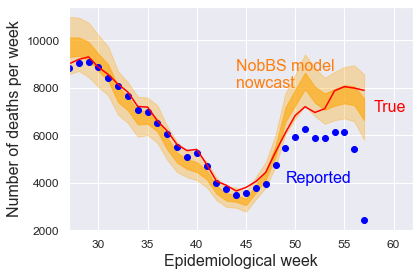

In [43]:
plot_results_with_annotation(data_new[data_new['Release'] <= '2021-02-08'],
                             data_recent, resultsnobbs, show_x=True, show_y=True, show_legend=False)
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/brazil_nowcast_2D_nobbs.pdf', bbox_inches = 'tight')

# Plot delays

In [15]:
ground_truth, _   = nowcasting_prep(data_new, data_new.Date.values[-1], maxD=12)
ground_truth = ground_truth.iloc[:,:-1] # remove the all_deaths
ground_truth

,0,1,2,3,4,5,6,7,8,9,10,11,12
week,,,,,,,,,,,,,
0,3386,2320,847,572,146,269,166,220,158,92,60,86,632
1,3376,2542,958,299,349,234,233,213,98,74,114,60,657
2,3649,2493,572,609,351,247,260,126,75,86,72,94,619
3,4308,1483,979,517,362,279,164,106,67,90,78,60,549
4,2100,3209,1165,545,311,212,127,124,100,93,43,65,480
5,3021,2596,786,446,208,159,153,105,92,74,71,31,531
6,2752,2559,774,357,230,176,129,148,58,62,49,71,478
7,2704,2314,595,320,213,171,143,91,64,71,52,33,499
8,2631,2208,632,381,209,147,132,66,94,69,50,61,499


In [73]:
def plot_delays(ground_truth, fits, text, show_xlab=True, 
                show_ylab=True, show_legend=True,
               cri=50):
    
    fit_n_predict = fits.extract()['n_predict']
    n_predict = fit_n_predict.mean(axis = 0)
    n_predict_q025 = np.quantile(fit_n_predict,0.025,axis=0)
    n_predict_q975 = np.quantile(fit_n_predict,0.975,axis=0)
    n_predict_q25 = np.quantile(fit_n_predict,0.25,axis=0)
    n_predict_q75 = np.quantile(fit_n_predict,0.75,axis=0)
    
    ground_truth = ground_truth.iloc[0:n_predict.shape[0],:]
    
    if cri == 50:
        n_predict_low = n_predict_q25
        n_predict_high = n_predict_q75
    else:
        n_predict_low = n_predict_q025
        n_predict_high = n_predict_q975
    
    sns.set_palette(sns.color_palette("tab10"))
    x_true = ground_truth.index + 27
    x_nowcast =  np.array(range(n_predict_low.shape[0])) + 27

    plt.plot(x_true, ground_truth.iloc[:,0].values, ls = '-', alpha = 1,
             label = str(0))
    plt.fill_between(x_nowcast, n_predict_low[:,0],n_predict_high[:,0], alpha = 0.3)

    for c in range(1,6):
        plt.plot(x_true[0:-c], ground_truth.iloc[:,c].values[0:-c], ls = '-', label = str(c))
        plt.fill_between(x_nowcast, n_predict_low[:,c],n_predict_high[:,c], alpha = 0.3)

    if show_legend:
        plt.legend(ncol=3, loc='upper right',  title = 'Reporting delay (weeks)', 
                   title_fontsize=12, fontsize=12,)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.text(33, 3900, text, bbox=dict(alpha=0.1), fontsize=20)
#     plt.text(31, 3900, text, bbox=dict(alpha=0.1), fontsize=20) # for poster

    if show_xlab:
        plt.xlabel('Epidemiological week', fontsize=16)
    if show_ylab:
#         plt.ylabel('Number of deaths per week', fontsize=16)  # single plot
        fig.text(0.00001, 0.5, 'Number of deaths per week', va='center', rotation='vertical', fontsize=14)

    
    if cri == 95:
        plt.ylim(0,5000)
    
    plt.tight_layout()

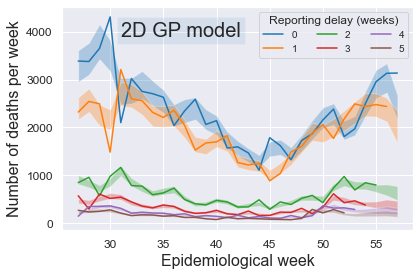

In [72]:
plot_delays(ground_truth, fit_2d_add, '2D GP model', show_legend=True)
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/poster_delays.pdf', bbox_inches = 'tight')
plt.show()

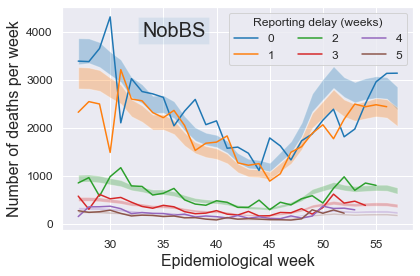

In [56]:
# plot_delays(ground_truth, fit_2d_mix, '2D mixture GP model', show_legend=False)
# plot_delays(ground_truth, fit_4compSE, '1D split SE+SE', show_legend=False)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_legend=True)
plt.show()


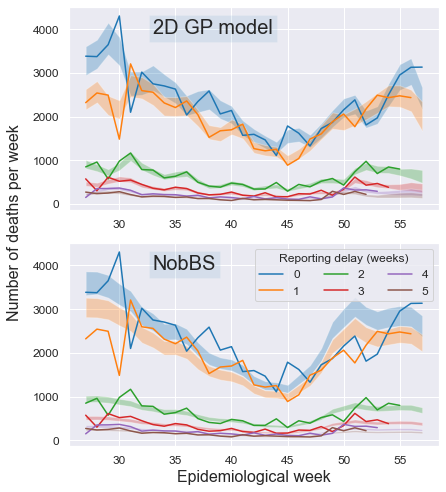

In [85]:
# plt.figure(figsize=(5.5,7))
plt.figure(figsize=(6,7))

plt.subplot(2,1,1)
plot_delays(ground_truth, fit_2d_add, '2D GP model', show_ylab=False, show_xlab=False, show_legend=False)
plt.subplot(2,1,2)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_ylab=False, show_legend=True)
plt.tight_layout()
plt.text(20, 5000, 'Number of deaths per week', va='center', rotation='vertical', fontsize=16)

plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/delays_combined_nobbs_and_2d_additive.pdf', bbox_inches='tight') 

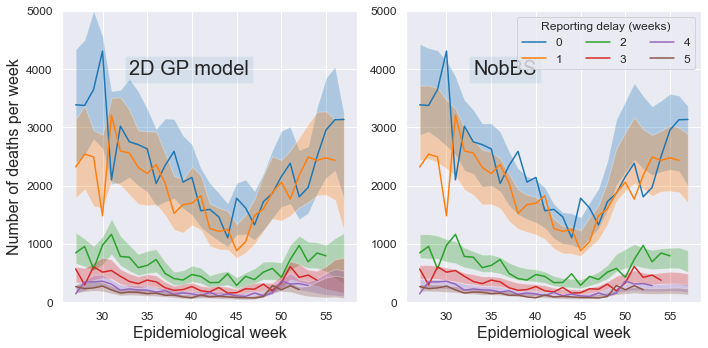

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_delays(ground_truth, fit_2d_add, '2D GP model', show_legend=False, cri=95)
plt.subplot(1,2,2)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_ylab=False, show_legend=True, cri=95)
plt.tight_layout()
plt.show()
# # plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/delays_combined_2d_nobbs_crI95.pdf', bbox_inches = 'tight')

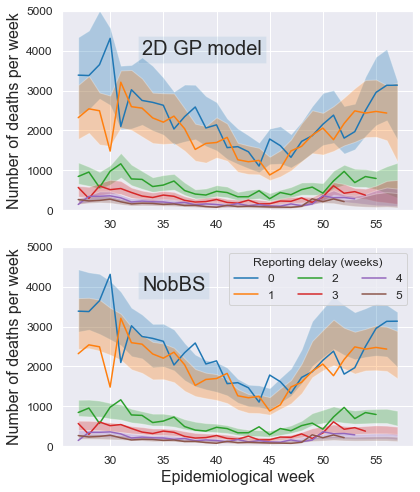

In [28]:
plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plot_delays(ground_truth, fit_2d_add, '2D GP model', show_xlab=False, show_legend=False, cri=95)
plt.subplot(2,1,2)
plot_delays(ground_truth, fit_nobbs, 'NobBS', show_legend=True, cri=95)
plt.tight_layout()
# plt.show()
# plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/delays_combined_2d_add_nobbs_crI95_vertical.pdf', bbox_inches = 'tight')

## Figure for the presentation

In [107]:
reporting_matrix, _   = nowcasting_prep(data_new, nowcast_date, maxD=12)
reporting_matrix = reporting_matrix.iloc[:,:-1] # remove the all_deaths

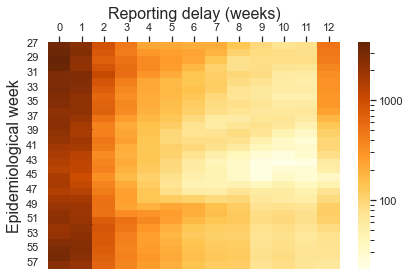

In [106]:
from matplotlib.colors import LogNorm

fit_n_predict = fit_2d_add.extract()['n_predict'].mean(axis = 0)
fit_n_predict_df = pd.DataFrame(fit_n_predict)

x = fit_n_predict
# x.index = x.index.astype(int) + 27

yticklabels = range(27, 59, 2)
yticks = np.linspace(0, 30, 16, dtype=np.int)


cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
ax = sns.heatmap(x, mask= x == 0, cmap="YlOrBr",
            cbar=True,
            norm=LogNorm(vmin=int(x.min())+0.5, vmax=int(x.max())),
             yticklabels=yticklabels
                )
           #cbar_kws={"ticks":cbar_ticks})
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.set_yticks(yticks)

plt.ylabel('Epidemiological week', fontsize=16)
plt.xlabel('Reporting delay (weeks)', fontsize=16)
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([str(el) for el in cbar_ticks])

# plt.tick_params(axis='both', which='major', labelsize=12,
#                 labelbottom = True, bottom=False, top = False,
#                 labeltop=False)

# plt.text(26*0.95, 2.95, 'C', size=20)
plt.tight_layout()


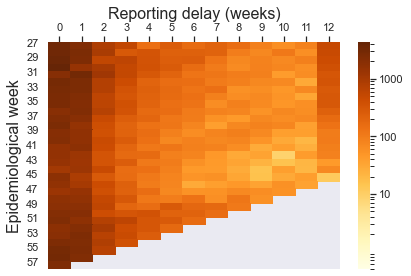

In [109]:
x = reporting_matrix.values
# x.index = x.index.astype(int) + 27

yticklabels = range(27, 59, 2)
yticks = np.linspace(0, 30, 16, dtype=np.int)


cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
ax = sns.heatmap(x, mask= x == 0, cmap="YlOrBr",
            cbar=True,
            norm=LogNorm(vmin=int(x.min())+0.5, vmax=int(x.max())),
             yticklabels=yticklabels
                )
           #cbar_kws={"ticks":cbar_ticks})
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.set_yticks(yticks)

plt.ylabel('Epidemiological week', fontsize=16)
plt.xlabel('Reporting delay (weeks)', fontsize=16)
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([str(el) for el in cbar_ticks])

# plt.tick_params(axis='both', which='major', labelsize=12,
#                 labelbottom = True, bottom=False, top = False,
#                 labeltop=False)

# plt.text(26*0.95, 2.95, 'C', size=20)
plt.tight_layout()


In [113]:
def fill_where_zeroes(reported, nowcasted):
    for i in range(reported.shape[0]):
        for j in range(reported.shape[1]):
            if reported[i,j] == 0:
                reported[i,j] = nowcasted[i,j]
    return reported

reporting_matrix_filled = fill_where_zeroes(reporting_matrix.values, fit_n_predict)

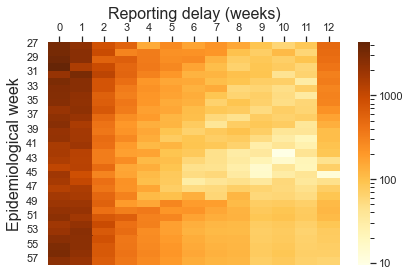

In [116]:
x = reporting_matrix_filled
# x.index = x.index.astype(int) + 27

yticklabels = range(27, 59, 2)
yticks = np.linspace(0, 30, 16, dtype=np.int)


cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
ax = sns.heatmap(x, mask= x == 0, cmap="YlOrBr",
            cbar=True,
            norm=LogNorm(vmin=int(x.min())+0.5, vmax=int(x.max())),
             yticklabels=yticklabels
                )
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.set_yticks(yticks)

plt.ylabel('Epidemiological week', fontsize=16)
plt.xlabel('Reporting delay (weeks)', fontsize=16)
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([str(el) for el in cbar_ticks])

plt.tight_layout()

plt.savefig('C:/Users/iwona/Desktop/nowcasting/figures/presentation_filled_matrix.pdf', bbox_inches = 'tight')

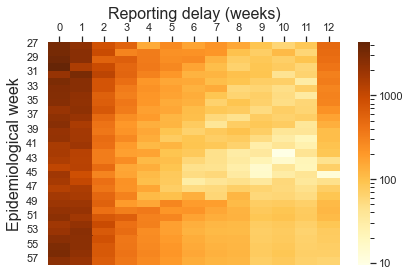

In [118]:
fit_n_predict_nobbs = fit_nobbs.extract()['n_predict'].mean(axis = 0)
fit_n_predict_df_nobbs = pd.DataFrame(fit_n_predict)
reporting_matrix_filled_nobbs = fill_where_zeroes(reporting_matrix.values, fit_n_predict_nobbs)

x = reporting_matrix_filled_nobbs
# x.index = x.index.astype(int) + 27

yticklabels = range(27, 59, 2)
yticks = np.linspace(0, 30, 16, dtype=np.int)


cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
ax = sns.heatmap(x, mask= x == 0, cmap="YlOrBr",
            cbar=True,
            norm=LogNorm(vmin=int(x.min())+0.5, vmax=int(x.max())),
             yticklabels=yticklabels
                )
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.set_yticks(yticks)

plt.ylabel('Epidemiological week', fontsize=16)
plt.xlabel('Reporting delay (weeks)', fontsize=16)
plt.yticks(rotation=0)

cbar = ax.collections[0].colorbar
cbar_ticks = [0, 0.1, 10, 100, 1000, 10000]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([str(el) for el in cbar_ticks])

plt.tight_layout()
